<a href="https://colab.research.google.com/github/boyerb/Investments/blob/master/Ex10_FamaFrenchFive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Investment Analysis**, Bates, Boyer, Fletcher

# Example Chapter 10: The Fama French Five Model
  

### Imports and Setup

In [64]:
!curl -O https://raw.githubusercontent.com/boyerb/Investments/master/functions/simple_finance.py
import simple_finance as sf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20291  100 20291    0     0  79668      0 --:--:-- --:--:-- --:--:-- 79885


### Pull Data on Beta Strategy and Estaimte the FF5 Alpha for each Decile

In [68]:
# Choose the strategy
dat=sf.get_ff_strategies(stype='beta',details=False)

# Initialize lists to store intercepts and confidence intervals
intercepts = []
conf_intervals = []

dat['exmkt']=dat['mkt']-dat['rf']
# Loop through each column corresponding to Dec 1 - Dec 10
for column in [f"Dec {i}" for i in range(1, 11)]:
    y = dat[column]-dat['rf']  # Dependent variable (Decile return)
    X = dat[['exmkt','smb','hml','cma','rmw']]  # Independent variable (Market excess return)
    X = sm.add_constant(X)    # Add constant to X for intercept

    # Fit regression model
    model = sm.OLS(y, X).fit()

    # Get the intercept and 95% confidence intervals
    intercept = model.params['const'] * 12  # Multiply intercept by 12
    ci_lower, ci_upper = model.conf_int().iloc[0] * 12  # Multiply confidence intervals by 12

    # Get the intercept and 95% confidence intervals
    intercepts.append(intercept)  # Append intercept to list
    conf_intervals.append([ci_lower, ci_upper])  # Append 95% CI for the intercept

# Convert results to DataFrame for easier manipulation
results_df = pd.DataFrame({
    "Decile": [f"Dec {i}" for i in range(1, 11)],
    "Intercept": intercepts,
    "CI_Lower": [ci[0] for ci in conf_intervals],
    "CI_Upper": [ci[1] for ci in conf_intervals]
})

### Plot Alphas and 95% Confindence Intervals

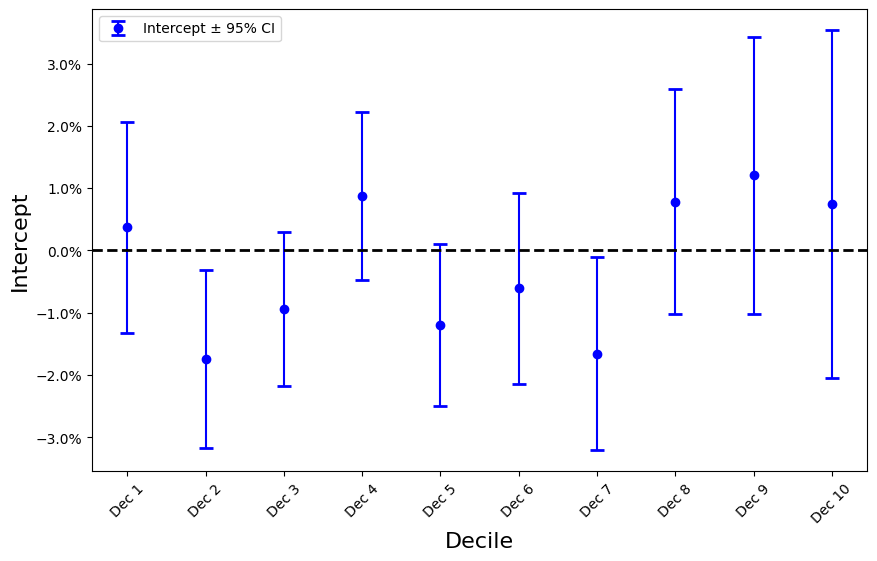

In [67]:
# Plot the intercepts with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Decile"], results_df["Intercept"],
             yerr=[results_df["Intercept"] - results_df["CI_Lower"],
                   results_df["CI_Upper"] - results_df["Intercept"]],
             fmt='o', capsize=5, capthick=2, label="Intercept ± 95% CI", color='b')

# Labels and title
plt.xlabel("Decile",fontsize=16)
plt.ylabel("Intercept",fontsize=16)
#plt.title("Regression Intercepts with 95% Confidence Intervals")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Reference line at 0
plt.legend()
# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))

# Show the plot
plt.show()

### Perform Out of Sample Test of Trading Strategy

In [70]:
start_date = '1993-01'
end_date = '2024-12'

tangent_list=[]
for date in pd.date_range(start=start_date, end=end_date, freq='ME'):
    # Subset data to include all observations before the current date
    date_period = pd.Period(date, freq='M')
    subset = dat.loc[dat.index < date_period]
    factors = subset[['exmkt','smb','hml','cma','rmw']]
    er = factors.mean().to_numpy()
    cov=factors.cov().to_numpy()
    t_weights, t_er, t_vol = sf.tangent_portfolio(er, cov, factors=True)
    nextdate=dat.loc[dat.index == date_period]
    tangent = (t_weights[0] * nextdate['mkt'] +
               t_weights[1] * nextdate['smb'] +
               t_weights[2] * nextdate['hml'] +
               t_weights[3] * nextdate['cma'] +
               t_weights[4] * nextdate['rmw']
               ).iloc[0]
        # Store results in a dictionary
    results_dict = {
            'date': pd.Period(date, freq='M'),
            'tangent': tangent,  # Replace with desired operation
            'rf': nextdate['rf'].iloc[0]     # Replace with desired operation
        }

    # Append the result to the list
    tangent_list.append(results_dict)

# Concatenate results into a single DataFrame
tangent_df = pd.DataFrame(tangent_list).set_index('date')

tangent_df['extan']=tangent_df['tangent']-tangent_df['rf']
oos_tsharpe = tangent_df['extan'].mean()*12/(tangent_df['tangent'].std()*np.sqrt(12))
print(oos_tsharpe)
tsample=dat[dat.index.year>1993].copy()
mkt_sharpe = tsample['exmkt'].mean()*12/(tsample['mkt'].std()*np.sqrt(12))
print(mkt_sharpe)

0.7896235984648017
0.5739792559251692
